In [1]:
import pandas as pd
import numpy as np
import reportsutils as utils
from matplotlib import pyplot



In [10]:
countries_list = ["Slovakia", "Slovenia", "Czechia","Poland", "Bulgaria", "Montenegro", "Serbia"]

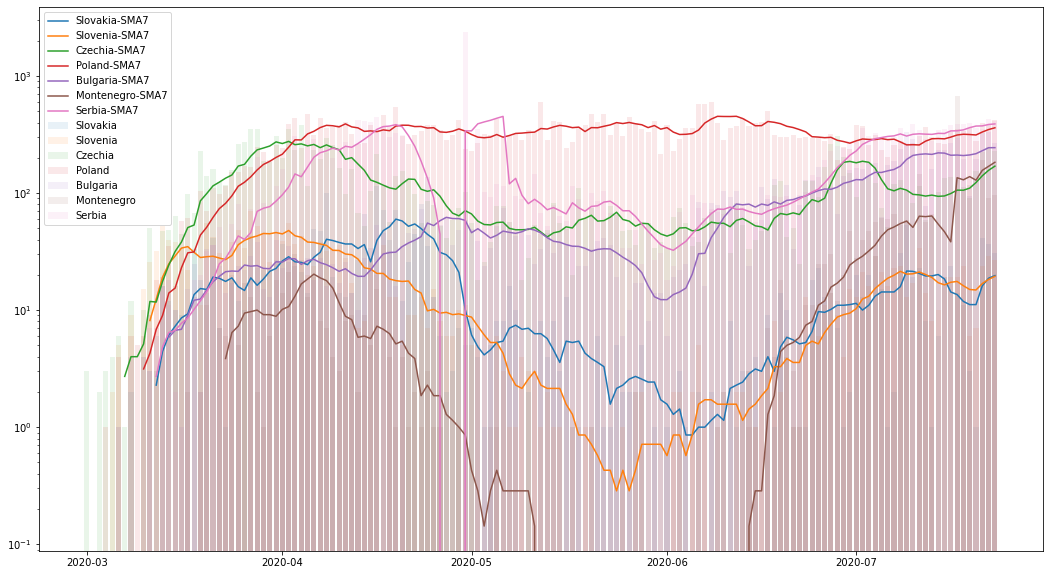

In [13]:
pyplot.figure(figsize=(18,10))

ax = pyplot.subplot(111)
ax.xaxis_date()

column_name = 'Confirmed_Change'

for country in countries_list:
    country_df = utils.get_country_report(country)
    #country_df = country_df[country_df.index >pd.to_datetime('01-05-2020',dayfirst=True)]
    
    country_df[column_name+'_SMA7'] = country_df[column_name].rolling(window=7).mean()
    ax.bar(country_df.index, country_df[column_name].values, label=country, alpha=0.1)
    ax.plot(country_df.index, country_df[column_name+'_SMA7'].values, label=country + '-SMA7') 

ax.legend()
#ax.set_ylim(top=800)
pyplot.yscale("log")
pyplot.show()

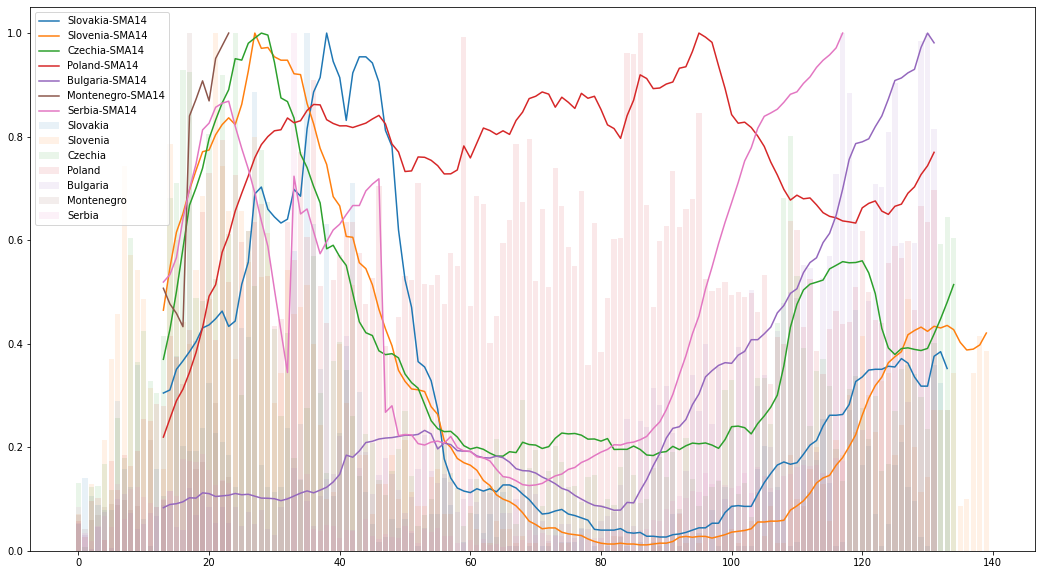

In [8]:
pyplot.figure(figsize=(18,10))

ax = pyplot.subplot(111)

for country in countries_list:
    country_df = utils.get_country_report(country,True,False)
    #country_df = country_df[country_df.Date >pd.to_datetime('01-05-2020',dayfirst=True)]

    country_df['Confirmed_Change_Normalized'] = utils.normalize(country_df['Confirmed_Change'])
    condition_row = country_df[country_df.Confirmed_Change_Normalized >= 0.05].iloc[0]
    country_df = country_df[condition_row.name:]
    
    country_df['Confirmed_Change_SMA7'] = utils.normalize(country_df['Confirmed_Change'].rolling(window=7).mean())
    country_df['Confirmed_Change_SMA14'] = utils.normalize(country_df['Confirmed_Change'].rolling(window=14).mean())

    #country_df.dropna(inplace=True, subset=['Confirmed_Change_SMA14'])

    country_df.reset_index(inplace=True, drop=True)

    ax.bar(country_df.index, country_df['Confirmed_Change_Normalized'].values, label=country, alpha=0.1)
    ax.plot(country_df.index, country_df['Confirmed_Change_SMA14'].values, label=country + '-SMA14') 

ax.set_ylim(bottom=0)
ax.legend()
pyplot.show()


In [23]:
column_name = "Confirmed_Change"
start_date = pd.to_datetime('01-04-2020', dayfirst=True)

moscow_df = utils.get_region_report("Russia", "Москва")[start_date:]
regions_df = utils.get_regions_report_by_column("Russia", column_name, exclude=["Москва"], start_date=start_date)


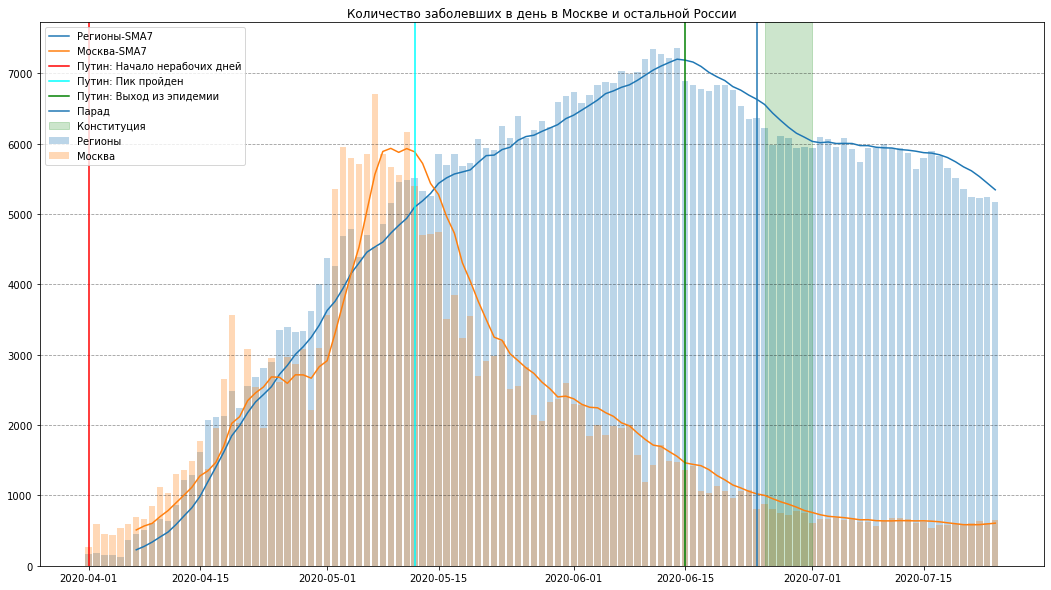

In [25]:
pyplot.figure(figsize=(18,10))

ax = pyplot.subplot(111)
ax.xaxis_date()

regions_df['Total'] = 0
regions_df['Total'] = regions_df.sum(axis = 1)

ax.bar(regions_df.index, regions_df['Total'].values, label = 'Регионы', alpha=0.3)
ax.plot(regions_df.index, regions_df['Total'].rolling(window=7).mean(), label= 'Регионы-SMA7')

ax.bar(moscow_df.index, moscow_df[column_name].values, label = 'Москва', alpha = 0.3)
ax.plot(moscow_df.index, moscow_df[column_name].rolling(window=7).mean(), label= 'Москва-SMA7')


utils.draw_key_russian_dates_on_plot(ax)
#ax.axhspan(5700, 6100, 0.75, 0.9, alpha = 0.4, color = 'Grey')
#ax.axhspan(500, 700, 0.78, 0.95, alpha = 0.4, color = 'Grey', label = "Неизменное число заболевших")

#ax.set_ylim(bottom=5000, top = 6500)
ax.legend(loc='upper left')
ax.set_title('Количество заболевших в день в Москве и остальной России')
ax.grid(axis='y', color='black', linestyle='dashed', alpha=0.4)
pyplot.show()

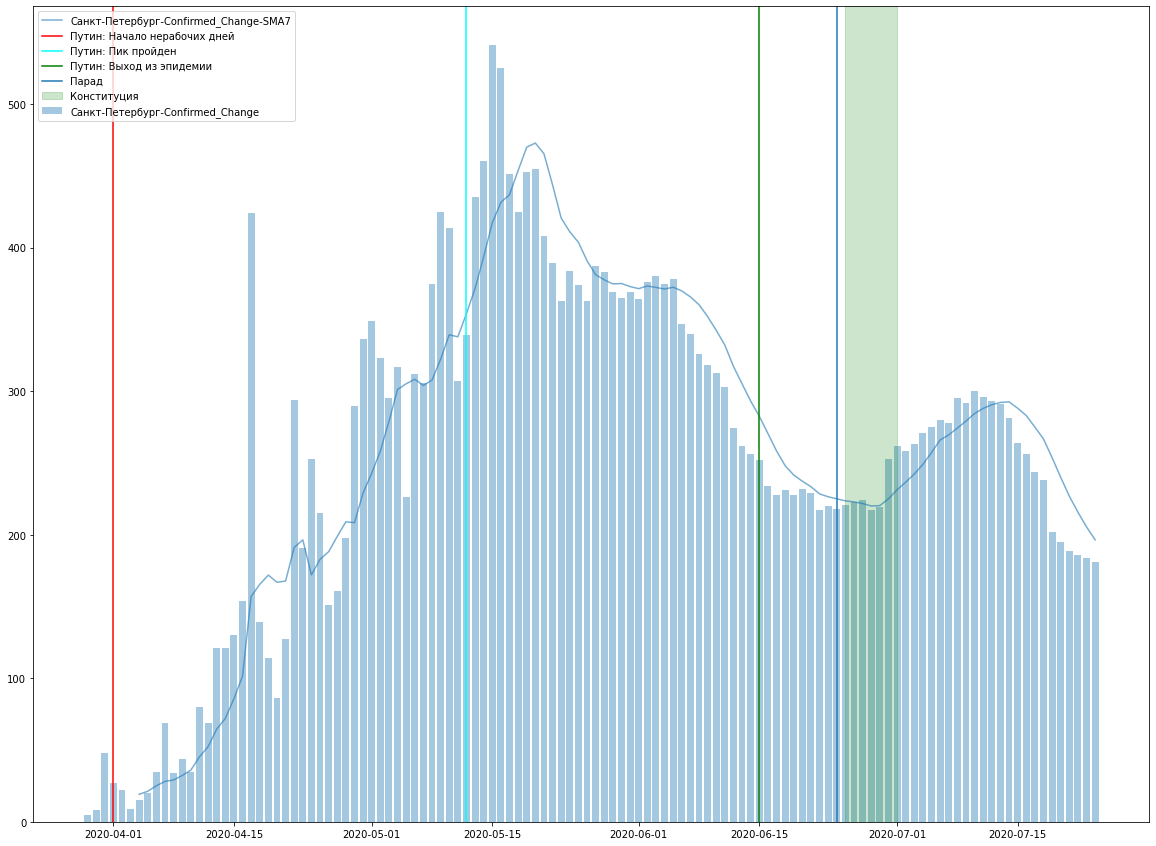

In [13]:
pyplot.figure(figsize=(20,15))

ax = pyplot.subplot(111)
ax.xaxis_date()

region_name = 'Санкт-Петербург'
column_name = 'Confirmed_Change'

ax.bar(region_dfs[region_name].index, region_dfs[region_name][column_name].values, label = region_name+'-'+column_name, alpha=0.4)
ax.plot(
    region_dfs[region_name].index,
    region_dfs[region_name][column_name].rolling(window=7).mean().values,
    label = region_name+'-'+column_name+'-SMA7',
    alpha=0.6)

utils.draw_key_russian_dates_on_plot(ax)

#ax.set_ylim(bottom=5000, top = 6500)
ax.legend(loc='upper left')
pyplot.show()

In [66]:
df = utils.get_country_report("Russia")["Confirmed_Change"].tail(21)
mad = df.mad()
mean = df.mean()
var = df.var()
std = df.std()

print(mean, std/mean)
df


6331.714285714285 0.04890746126086948


Date
2020-07-04    6632
2020-07-05    6736
2020-07-06    6611
2020-07-07    6368
2020-07-08    6562
2020-07-09    6509
2020-07-10    6635
2020-07-11    6611
2020-07-12    6615
2020-07-13    6537
2020-07-14    6248
2020-07-15    6422
2020-07-16    6428
2020-07-17    6406
2020-07-18    6234
2020-07-19    6109
2020-07-20    5940
2020-07-21    5842
2020-07-22    5862
2020-07-23    5848
2020-07-24    5811
Name: Confirmed_Change, dtype: int64